# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sqlalchemy import create_engine
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

% matplotlib inline
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterRespdata.db')
df = pd.read_sql_table('DisasterRespdata',engine)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.dropna(inplace=True)
df.shape

(10223, 40)

In [4]:
X = df['message']
Y = df[df.columns[4:-1]]
Y.tail()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather
12411,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
12412,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12413,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12414,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12416,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
Y.describe()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather
count,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.0,...,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000
mean,0.669764,0.351756,0.000978,0.386090,0.055659,0.033650,0.020640,0.012814,0.004304,0.0,...,0.002739,0.007434,0.016727,0.148880,0.025237,0.032182,0.003815,0.082265,0.005869,0.019075
std,0.470321,0.477542,0.031262,0.486875,0.229273,0.180334,0.142182,0.112478,0.065467,0.0,...,0.052266,0.085905,0.128253,0.355988,0.156852,0.176493,0.061650,0.274782,0.076389,0.136794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2. Write a tokenization function to process your text data

In [6]:
def tokenize(text):
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    text = re.sub(r"[0-9]", "", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    tokens=[word for word in tokens if word in list(wn.words())]
    tokens=[word for word,pos in pos_tag(tokens) if not pos=='UH']
    tokens=[word for word,pos in pos_tag(tokens) if not pos=='NNP']
    tokens=[word for word,pos in pos_tag(tokens) if not pos=='PRP']
    
    if len(tokens)==0:
        tokens=['none']

    return tokens

class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [7]:
tokenize('Michael air food want')

['michael', 'air', 'food', 'want']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [8]:
pipeline = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=tokenize)),
        ('clf', MultiOutputClassifier(RandomForestClassifier())),
    ])
pipeline = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('starting_verb', StartingVerbExtractor())
    ])),

    ('clf', RandomForestClassifier())
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,train_size=0.7,random_state=np.random.randint(0,42))
# train classifier
pipeline.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_d...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [10]:
# predict on test data
y_pred = pipeline.predict(X_test)
y_pred.shape

(3067, 35)

In [11]:
x=list(range(0,89))
y=np.array(x)
y_2=np.array([np.random.choice(np.array([1,0]))*num for num in y])
target_names = ['class 0', 'class 1', 'class 2']
print(precision_recall_fscore_support(y,y_2,average='micro')[2])

0.505617977528


In [12]:
def display_results(y_test, y_pred):
    results=pd.DataFrame(columns=y_test.columns,index=['confusion_mat','precision','recall','f-score'])
    i=0
    for column in y_test.columns:
        results.loc['confusion_mat',column] = confusion_matrix(y_test.loc[:,column], y_pred[:,i])
        results.loc['precision',column]=precision_recall_fscore_support(y_test.loc[:,column] ,y_pred[:,i],average='micro')[0]
        results.loc['recall',column]=precision_recall_fscore_support(y_test.loc[:,column] ,y_pred[:,i],average='micro')[1]
        results.loc['f-score',column]=precision_recall_fscore_support(y_test.loc[:,column] ,y_pred[:,i],average='micro')[2]
        i=i+1
    fig=plt.figure(figsize=(12,8))
    plt.barh(y_test.columns,results.loc['f-score',:])
    mean_accuracy_score=results.loc['f-score',:].mean()
    std_accuracy_score=results.loc['f-score',:].std()
    accuracy_sorted=list(results.loc['f-score',:].sort_values(ascending=True))
    lo_accuracy_labels=[]
    for sort_acc in accuracy_sorted[0:7]:
        for col in results.columns:
            if results.loc['f-score',col]==sort_acc and col not in lo_accuracy_labels:
                lo_accuracy_labels.append(col)
    return results,mean_accuracy_score,lo_accuracy_labels


Mean Accuracy: 0.9329172294936888
Lo Accuracy:['related', 'aid_related', 'request', 'weather_related', 'food', 'other_aid', 'shelter']


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather
confusion_mat,"[[416, 585], [699, 1367]]","[[1788, 204], [919, 156]]","[[3062, 0], [5, 0]]","[[1634, 255], [987, 191]]","[[2884, 2], [181, 0]]","[[2951, 4], [112, 0]]","[[2992, 0], [75, 0]]","[[3025, 0], [42, 0]]","[[3052, 1], [14, 0]]",[[3067]],...,"[[3056, 0], [11, 0]]","[[3050, 0], [17, 0]]","[[3019, 1], [46, 1]]","[[2577, 26], [451, 13]]","[[2975, 4], [87, 1]]","[[2970, 3], [90, 4]]","[[3054, 0], [13, 0]]","[[2794, 10], [261, 2]]","[[3047, 0], [20, 0]]","[[3005, 2], [60, 0]]"
precision,0.58135,0.633844,0.99837,0.595044,0.940333,0.962178,0.975546,0.986306,0.995109,1,...,0.996413,0.994457,0.984676,0.844473,0.970329,0.969677,0.995761,0.91164,0.993479,0.979785
recall,0.58135,0.633844,0.99837,0.595044,0.940333,0.962178,0.975546,0.986306,0.995109,1,...,0.996413,0.994457,0.984676,0.844473,0.970329,0.969677,0.995761,0.91164,0.993479,0.979785
f-score,0.58135,0.633844,0.99837,0.595044,0.940333,0.962178,0.975546,0.986306,0.995109,1,...,0.996413,0.994457,0.984676,0.844473,0.970329,0.969677,0.995761,0.91164,0.993479,0.979785


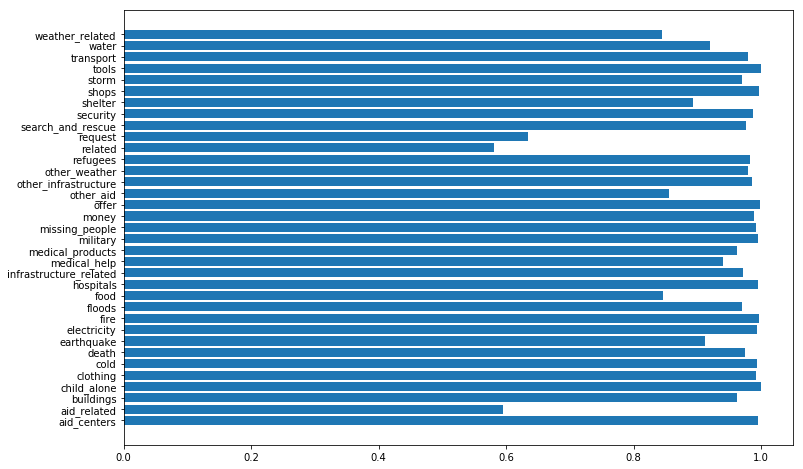

In [13]:
 # display results
results,mean_accuracy_score,lo_accuracy_labels=display_results(y_test, y_pred)
print('Mean Accuracy: {}'.format(mean_accuracy_score))
print('Lo Accuracy:{}'.format(lo_accuracy_labels))
results

In [14]:
X_train.apply(tokenize)

8225     [future, haiti, u, like, young, take, responsi...
5313                  [cyclone, need, information, please]
584             [trying, operate, school, work, look, see]
1931                          [haitian, government, offer]
9532     [good, morning, please, help, understand, obse...
9584     [na, make, know, today, service, sm, urgency, ...
7937     [please, give, help, never, find, please, help...
2597                      [need, work, hunger, killing, u]
7533       [fidelity, mutual, affection, obedience, union]
12191                                     [khan, district]
4494                 [note, request, know, school, reopen]
7806     [give, big, thanks, message, may, god, bless, ...
6889                       [ask, fr, help, answer, hungry]
1642        [true, people, go, senegal, switzerland, visa]
4312     [information, propaganda, live, even, little, ...
2055     [need, food, clothes, dear, friend, help, love...
8531                                [disconnect, interne

### 6. Improve your model
Use grid search to find better parameters. 

In [15]:
def build_model():
    pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', RandomForestClassifier())
    ])

    parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
        'features__text_pipeline__vect__max_features': (None, 5000, 10000),
        'features__text_pipeline__tfidf__use_idf': (True, False),
        'clf__n_estimators': [50, 100, 200],
        'clf__min_samples_split': [2, 3, 4],
        'features__transformer_weights': (
            {'text_pipeline': 1, 'starting_verb': 0.5},
            {'text_pipeline': 0.5, 'starting_verb': 1},
            {'text_pipeline': 0.8, 'starting_verb': 1},
        )
    }

    cv = GridSearchCV(pipeline, param_grid=parameters)

    return cv

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,train_size=0.7,random_state=np.random.randint(0,42))
# train classifier
model = build_model()
pipeline.fit(X_train, y_train)


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_d...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [16]:
y_pred = model.predict(X_test)

TypeError: no supported conversion for types: (dtype('float64'), dtype('O'))

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
 # display results
results,mean_accuracy_score,lo_accuracy_labels=display_results(y_test, y_pred)
print('Mean Accuracy: {}'.format(mean_accuracy_score))
print('Lo Accuracy:{}'.format(lo_accuracy_labels))
results

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.